# Harmonic Networks: Predicting Only Joint Heatmaps (Regression Values)

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import os
import cv2
import sys
from keras.utils import to_categorical
import time
import torch
import torch.nn as nn
from torch_localize import localized_module
from torch_dimcheck import dimchecked
from harmonic.d2 import HConv2d, ScalarGate2d, avg_pool2d, BatchNorm2d, upsample_2d, cat2d, Dropout2d
from harmonic.cmplx import from_real
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
import torch.nn.functional as F

Using TensorFlow backend.


## Training and Validation Set

In [3]:
image_adr = 'SMALL_5K_IMAGES/'
mask_adr = 'SMALL_5K_HEATMAPS/'

images = sorted(os.listdir(image_adr))
masked = sorted(os.listdir(mask_adr))

In [4]:
print(len(images))
print(len(masked))

5000
5000


In [5]:
np.random.seed(23)
order = np.random.permutation(len(images))
X_train = order[:int(0.8*len(order))]
X_valid = order[int(0.8*len(order)):]
print(len(X_train))
print(len(X_valid))

4000
1000


## Dataset

In [15]:
class Images(Dataset):

    def __init__(self, X_names, y_names, indices):
        self.X_names = X_names
        self.y_names = y_names
        self.indices = indices
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        X_name = image_adr + self.X_names[self.indices[idx]]
        y_name = mask_adr + self.y_names[self.indices[idx]]
        
        X = cv2.cvtColor(cv2.imread(X_name), cv2.COLOR_BGR2RGB).astype('float32')
        X /= 255
        
        r = X.shape[0]
        c = X.shape[1]
        r_pad = 0
        c_pad = 0
        
        while r % 16 != 0:
            r_pad += 1
            r += 1
            
        while c % 16 != 0:
            c_pad += 1
            c += 1
            
        X = np.pad(X, ((0, r_pad), (0, c_pad), (0, 0)), mode='constant', constant_values=0)
        X = self.to_tensor(X)
        
        y = cv2.imread(y_name, 0).astype('float32')/255*100  # For Heatmaps
        y = np.pad(y, ((0, r_pad), (0, c_pad)), mode='constant', constant_values=0)
        y = self.to_tensor(y)
        
        return {'X': X, 'y': y}

## Model

In [16]:
@localized_module
class FinalConvBlock(nn.Module):
    def __init__(self, in_repr, out_repr, size=3, pad=False):
        super(FinalConvBlock, self).__init__()

        self.in_repr = in_repr
        self.out_repr = out_repr
        
        self.conv1 = HConv2d(in_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})

    def forward(self, x):
        y = x
        
        y = self.conv1(y)
        y = y[0, ...]

        return y

@localized_module
class HNetConvBlock(nn.Module):
    def __init__(self, in_repr, out_repr, size=3, pad=False):
        super(HNetConvBlock, self).__init__()

        self.in_repr = in_repr
        self.out_repr = out_repr
        
        self.nonl1 = ScalarGate2d(out_repr)
        self.nonl2 = ScalarGate2d(out_repr)
        
        self.bnorm1 = BatchNorm2d(out_repr)
        self.bnorm2 = BatchNorm2d(out_repr)

        self.conv1 = HConv2d(in_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})
        self.conv2 = HConv2d(out_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})
        self.dropout = Dropout2d(p=0.3)

    def forward(self, x):
        y = x
        
        y = self.conv1(y)
        y = self.bnorm1(y)
        y = self.nonl1(y)
        y = self.conv2(y)
        y = self.bnorm2(y)
        y = self.nonl2(y)
        y = self.dropout(y)

        return y
    
@localized_module
class HNetUpSampleBlock(nn.Module):
    def __init__(self, in_repr, out_repr, size=3):
        super(HNetUpSampleBlock, self).__init__()

        self.in_repr = in_repr
        self.out_repr = out_repr
        self.nonl = ScalarGate2d(out_repr)
        self.bnorm1 = BatchNorm2d(out_repr)
        self.conv = HConv2d(in_repr, out_repr, size, conv_kwargs={'padding':(size-1)//2})

    def forward(self, x):
        y = x
        y = upsample_2d(y)
        y = self.conv(y)
        y = self.bnorm1(y)
        y = self.nonl(y)

        return y

In [17]:
layers = [(3,),
         (32,32),
         (64,64),
         (128,128),
         (256,256),
         (512,512)]

class HNet(nn.Module):

    def __init__(self, kernel):
        super(HNet, self).__init__()
        
        self.kernel_size = kernel
        
        self.conv_down1 = HNetConvBlock(layers[0], layers[1])
        self.conv_down2 = HNetConvBlock(layers[1], layers[2])
        self.conv_down3 = HNetConvBlock(layers[2], layers[3])
        self.conv_down4 = HNetConvBlock(layers[3], layers[4])
        self.conv_down5 = HNetConvBlock(layers[4], layers[5])
        
        self.conv_upsample1 = HNetUpSampleBlock(layers[5], layers[4], self.kernel_size)
        self.conv_up1 = HNetConvBlock(layers[5], layers[4])
        
        self.conv_upsample2 = HNetUpSampleBlock(layers[4], layers[3], self.kernel_size)
        self.conv_up2 = HNetConvBlock(layers[4], layers[3])
        
        self.conv_upsample3 = HNetUpSampleBlock(layers[3], layers[2], self.kernel_size)
        self.conv_up3 = HNetConvBlock(layers[3], layers[2])
        
        self.conv_upsample4 = HNetUpSampleBlock(layers[2], layers[1], self.kernel_size)
        self.conv_up4 = HNetConvBlock(layers[2], layers[1])

        self.conv_up5 = FinalConvBlock(layers[1], (1,))
        

    @dimchecked
    def forward(self, x: ['n', 3, 'wi', 'hi']) -> ['n', -1, 'wo', 'ho']:
        x = from_real(x)
        y = x
        
        conv1 = self.conv_down1(y)
        pool1 = avg_pool2d(conv1, kernel_size=2)

        conv2 = self.conv_down2(pool1)
        pool2 = avg_pool2d(conv2, kernel_size=2)
        
        conv3 = self.conv_down3(pool2)
        pool3 = avg_pool2d(conv3, kernel_size=2)
        
        conv4 = self.conv_down4(pool3)
        pool4 = avg_pool2d(conv4, kernel_size=2)
        
        conv5 = self.conv_down5(pool4)

        up6 = self.conv_upsample1(conv5)
        merge6 = cat2d(conv4, layers[4], up6, layers[4])
        conv6 = self.conv_up1(merge6)
        
        up7 = self.conv_upsample2(conv6)
        merge7 = cat2d(conv3, layers[3], up7, layers[3])
        conv7 = self.conv_up2(merge7)

        up8 = self.conv_upsample3(conv7)
        merge8 = cat2d(conv2, layers[2], up8, layers[2])
        conv8 = self.conv_up3(merge8)
        
        up9 = self.conv_upsample4(conv8)
        merge9 = cat2d(conv1, layers[1], up9, layers[1])
        conv9 = self.conv_up4(merge9)
        
        output = self.conv_up5(conv9)
        
        return output

## Metrics

In [18]:
def dice_coef(input_, target):
    smooth = 1e-6
    iflat = input_[:,1,:,:]
    tflat = target[:,1,:,:]
    intersection = (iflat * tflat).sum(dim=(2,1))
    return torch.mean((2. * intersection + smooth) / (iflat.sum(dim=(2,1)) + tflat.sum(dim=(2,1)) + smooth))

def dice_loss(input_, target):
    return 1-dice_coef(input_, target)

def dice_coef_hard(input_, target):
    iflat = torch.argmax(input_, dim=1).type(torch.cuda.FloatTensor)
    tflat = target[:,1,:,:]
    intersection = (iflat * tflat).sum(dim=(2,1))
    return torch.mean((2. * intersection) / (iflat.sum(dim=(2,1)) + tflat.sum(dim=(2,1))))

## Training

In [18]:
batch_size = 1
n_epochs = 20

In [19]:
train = DataLoader(Images(images, masked, X_train), batch_size=1, num_workers=0, shuffle=False)
valid = DataLoader(Images(images, masked, X_valid), batch_size=1, num_workers=0, shuffle=False)

net = HNet(kernel=3)

loss_fn = nn.MSELoss()

n_params = 0

for param in net.parameters():
    n_params += param.numel()
    
print('n params:', n_params)

cuda = torch.cuda.is_available()
if cuda:
    net = net.cuda()
    loss_fn = loss_fn.cuda()
    
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

n params: 13430080


In [20]:
v_loss = []
t_loss = []


for ep in range(n_epochs):
    
    with tqdm(total=len(train), dynamic_ncols=True) as progress:
        
        loss_ = 0.
        acc_ = 0.
        acc_h_ = 0.
        
        progress.set_description('Epoch: %s' % str(ep+1))

        for idx, batch_data in enumerate(train):
            X, y = batch_data['X'].cuda(), batch_data['y'].cuda()

            optimizer.zero_grad()
            
            output = net(X)
            
            loss = loss_fn(output, y)
            
            loss.backward()
            optimizer.step()
            
            progress.update(1)
            
            loss_ += loss.item()
            
            progress.set_postfix(loss=loss_/(idx+1))

        loss_ /= len(train)
        
    progress.write('Validating ...')
    
    net.eval()
    
    with torch.no_grad():
        
        val_loss_ = 0.

        for idx, batch_data in enumerate(valid):
            X, y = batch_data['X'].cuda(), batch_data['y'].cuda()

            output = net(X)

            val_loss = loss_fn(output, y)
            val_loss_ += val_loss.item()


        val_loss_ /= len(valid)
        

        t_loss.append(loss_)
        v_loss.append(val_loss_)

        progress.write('Training MSE: {:.6f}\nValidation MSE: {:.6f}'.format(
            loss_, val_loss_))
        
    net.train()


Validating ...
Training MSE: 21.879605
Validation MSE: 20.553323



Validating ...
Training MSE: 19.719730
Validation MSE: 19.265058



Validating ...
Training MSE: 18.623228
Validation MSE: 18.319410



Validating ...
Training MSE: 17.864722
Validation MSE: 17.510450



Validating ...
Training MSE: 17.287019
Validation MSE: 16.952326



Validating ...
Training MSE: 16.841627
Validation MSE: 16.601222



Validating ...
Training MSE: 16.474407
Validation MSE: 16.289761



Validating ...
Training MSE: 16.154174
Validation MSE: 16.138954



Validating ...
Training MSE: 15.859774
Validation MSE: 15.992054



Validating ...
Training MSE: 15.614732
Validation MSE: 15.815353



Validating ...
Training MSE: 15.374763
Validation MSE: 15.731706



Validating ...
Training MSE: 15.183443
Validation MSE: 15.613673



Validating ...
Training MSE: 14.994225
Validation MSE: 15.610493



Validating ...
Training MSE: 14.819613
Validation MSE: 15.406573



Validating ...
Training MSE: 14.645365
Validation MSE: 15.309597



Validating ...
Training MSE: 14.462185
Validation MSE: 15.342247



Validating ...
Training MSE: 14.316342
Validation MSE: 15.329924



Validating ...
Training MSE: 14.175902
Validation MSE: 15.391738



Validating ...
Training MSE: 14.046299
Validation MSE: 15.144596



Validating ...
Training MSE: 13.902053
Validation MSE: 15.435806


## Model Performance

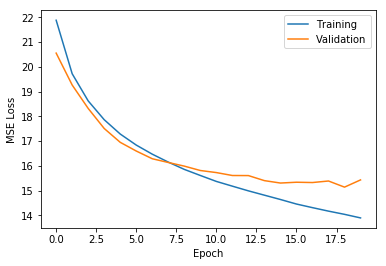

In [23]:
plt.figure(figsize=(6,4))

plt.plot(t_loss, label='Training')
plt.plot(v_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

## Sample Predictions

In [29]:
results[i].squeeze().cpu().numpy().shape

(192, 128)

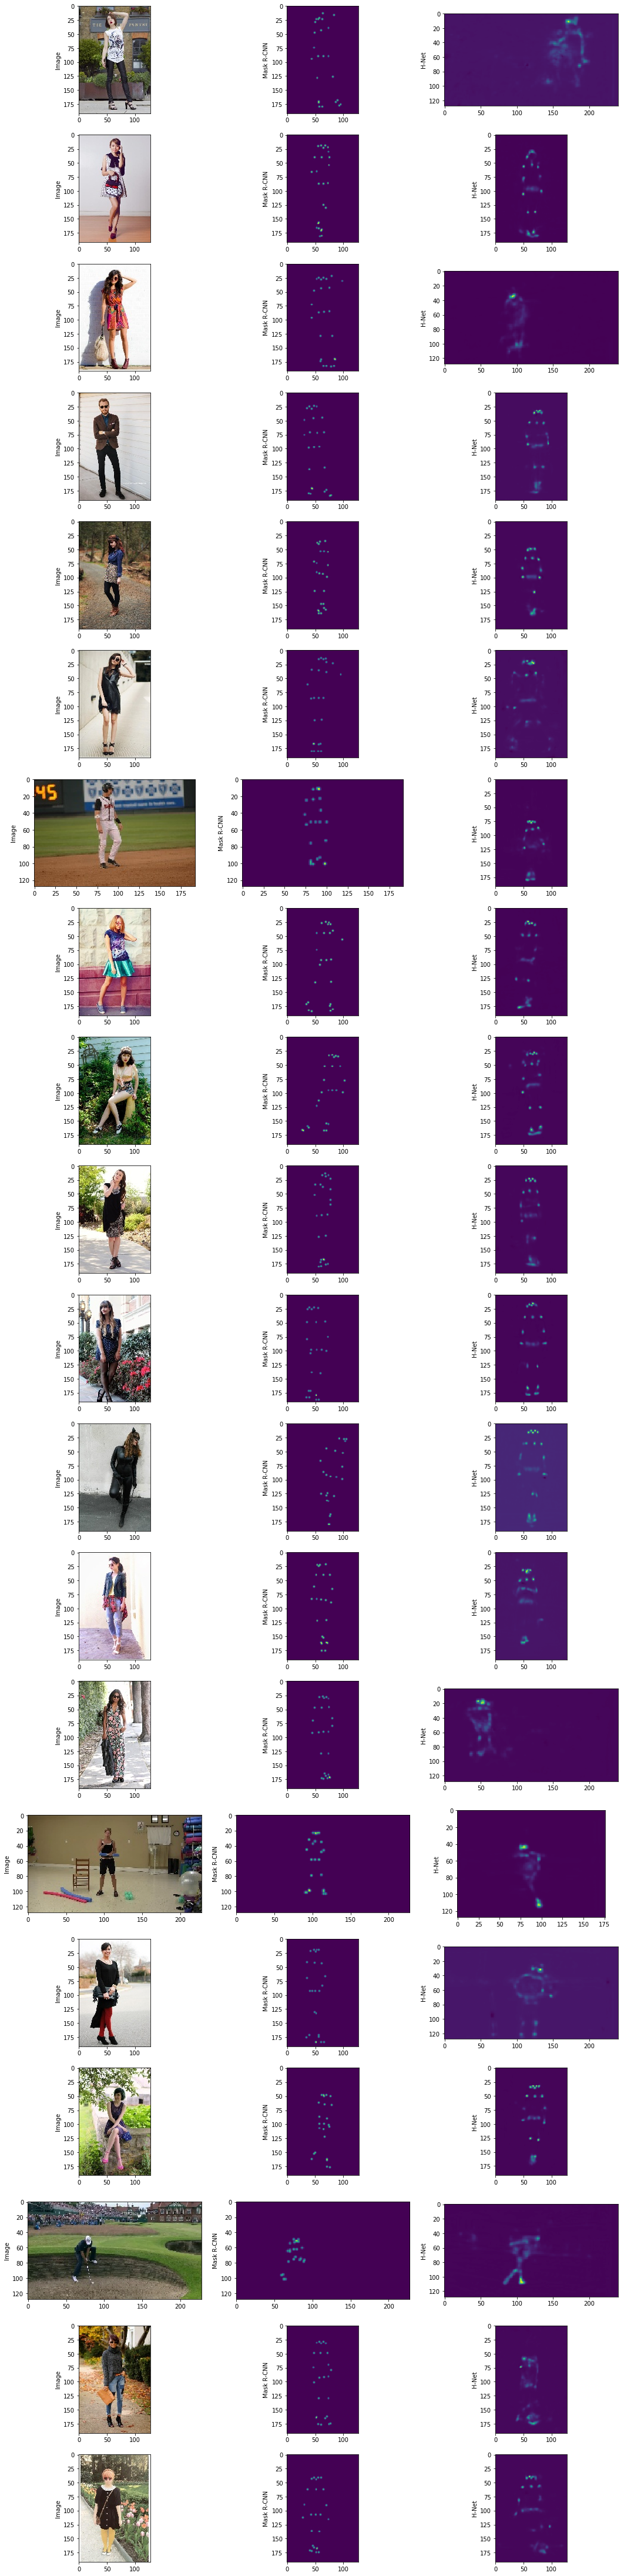

In [31]:
results = []

with torch.no_grad():
    for idx, batch_data in enumerate(valid):
        X, y = batch_data['X'].cuda(), batch_data['y'].cuda()
        output = net(X)
        results.append(output)
        
        if idx == 20:
            break
            
image_list = X_valid[40:60]

f, ax = plt.subplots(20,3, figsize=(18,80))
c_ = 0

for i in range(20):
    X_batch = cv2.cvtColor(cv2.imread(image_adr + images[image_list[i]]), cv2.COLOR_BGR2RGB)
    ax[i,0].imshow(X_batch)
    ax[i,1].imshow(cv2.imread(mask_adr + images[image_list[i]], 0))
    out = results[i].squeeze().cpu().numpy()
    out = (out-np.min(out))/(np.max(out)-np.min(out))
    ax[i,2].imshow(out)
    c_ += 1

for j in range(20):
    _ = ax[j,0].set_ylabel('Image')
    _ = ax[j,1].set_ylabel('Mask R-CNN')
    _ = ax[j,2].set_ylabel('H-Net')

## Model Save & Load

In [16]:
torch.save(net.state_dict(), 'harmonic_100ep_adam2e5_3232_512512_drop_bnorm.pt')
#model = torch.load('harmonic_100ep_adam2e5_3232_512512_drop_bnorm.pt')
#model.eval()

In [11]:
the_model = HNet(3)
the_model.load_state_dict(torch.load('harmonic_100ep_adam2e5_3232_512512_drop_bnorm.pt'))
the_model.eval()

HNet(
  (conv_down1): HNetConvBlock(
    (nonl1): ScalarGate2d(repr=(32, 32), mult=1)
    (nonl2): ScalarGate2d(repr=(32, 32), mult=1)
    (bnorm1): BatchNorm2d(repr=(32, 32), eps=0.01)
    (bnorm2): BatchNorm2d(repr=(32, 32), eps=0.01)
    (conv1): HConv2d(in=(3,), out=(32, 32), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (conv2): HConv2d(in=(32, 32), out=(32, 32), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (dropout): Dropout2d(p=0.1)
  )
  (conv_down2): HNetConvBlock(
    (nonl1): ScalarGate2d(repr=(64, 64), mult=1)
    (nonl2): ScalarGate2d(repr=(64, 64), mult=1)
    (bnorm1): BatchNorm2d(repr=(64, 64), eps=0.01)
    (bnorm2): BatchNorm2d(repr=(64, 64), eps=0.01)
    (conv1): HConv2d(in=(32, 32), out=(64, 64), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (conv2): HConv2d(in=(64, 64), out=(64, 64), size=3, radius=3, constr=True, trans=False, {'padding': 1}
    (dropout): Dropout2d(p=0.1)
  )
  (conv_down3): HNetConvBlock(
    (